In [1]:
%load_ext autoreload
%autoreload 2

Four (?) filters to apply 

1. consensus of reviewers 
2. at least one java faile has been modified 
3. at least more than one method have been modified 
4. at least once changed in the past (?)
    - for this, we will exclude only the cases where none of the modified methods has been changed in the past
    - e.g., for commit c at time t_c, m1, m2 modified.  
        m1 = [t_c, t1], m2 = \[t_c\] & t_c - t1 (, assumed to be less than a day)
        => while we should exclude the co-changes happened in c, <br/>
        we can still exploit the observation that m2 was shortly followed by the change in m1. 

In [2]:
import os, sys 
import json 
import numpy as np
import glob 
from tqdm import tqdm
import pandas as pd
import git
from typing import Dict, Iterator, List, Set, Tuple, Sequence, Optional
import matplotlib.pyplot as plt 
import seaborn as sns

### F1. consensus of reviewers &
### F2. at least one java faile has been modified 

In [83]:
# get the complete hunks with consensus_label (at line label & from Replication-Notebook.ipynb provided by the authors)
completed_df = pd.read_pickle("../data/complete_hunk_labels.pkl")

In [122]:
all_consensus_commits = {}
f1_f2_n_uniq_labels = {}
for proj, proj_df in completed_df.groupby('project'):
    all_consensus_commits[proj] = []
    f1_f2_n_uniq_labels[proj] = {}
    for rev_hash, proj_rev_df in proj_df.groupby('revision_hash'):
        is_none_flags = [l == 'None' for labels in proj_rev_df.label_dict_consensus.apply(
            lambda v:v.values()).values for l in labels] 
        has_none = any(is_none_flags)
        if not has_none:
            all_consensus_commits[proj].append(rev_hash) 
            uniq_labels = []
            for index, row in proj_rev_df.iterrows():
                issue_id = row.issue_id
                file_path = row.file
                if not file_path.endswith('.java'):
                    continue 
                for lno, lno_label in row.label_dict_consensus.items():
                    uniq_label = (issue_id, lno_label)
                    uniq_labels.append(uniq_label)

            uniq_labels = list(set(uniq_labels)) 
            if len(uniq_labels) > 0:
                f1_f2_n_uniq_labels[proj][rev_hash] = len(uniq_labels)

    ns = [n for n in f1_f2_n_uniq_labels[proj].values()]
    if len(ns) == 0:
        continue
    print ("{}: {} ~ {}, {}, {}"
        .format(
            proj, 
            np.min(ns), 
            np.max(ns), 
            np.round(np.mean(ns)), 
            np.round(np.median(ns))))

ant-ivy: 1 ~ 6, 2.0, 2.0
archiva: 1 ~ 4, 2.0, 2.0
commons-bcel: 1 ~ 4, 2.0, 2.0
commons-beanutils: 1 ~ 6, 2.0, 2.0
commons-codec: 1 ~ 5, 2.0, 2.0
commons-collections: 1 ~ 6, 2.0, 2.0
commons-compress: 1 ~ 5, 2.0, 2.0
commons-configuration: 1 ~ 6, 3.0, 3.0
commons-dbcp: 1 ~ 4, 2.0, 2.0
commons-digester: 1 ~ 4, 2.0, 2.0
commons-imaging: 1 ~ 4, 2.0, 2.0
commons-io: 1 ~ 5, 2.0, 2.0
commons-jcs: 1 ~ 5, 2.0, 2.0
commons-lang: 1 ~ 5, 2.0, 2.0
commons-math: 1 ~ 4, 2.0, 2.0
commons-net: 1 ~ 5, 2.0, 2.0
commons-scxml: 1 ~ 5, 3.0, 3.0
commons-validator: 1 ~ 6, 2.0, 2.0
commons-vfs: 1 ~ 5, 2.0, 2.0
eagle: 1 ~ 1, 1.0, 1.0
giraph: 1 ~ 5, 2.0, 1.0
gora: 1 ~ 5, 2.0, 1.0
jspwiki: 3 ~ 3, 3.0, 3.0
opennlp: 1 ~ 4, 2.0, 2.0
parquet-mr: 1 ~ 4, 2.0, 2.0
santuario-java: 1 ~ 5, 2.0, 1.0
systemml: 1 ~ 4, 3.0, 3.0
wss4j: 1 ~ 6, 2.0, 2.0


In [123]:
len(all_consensus_commits['ant-ivy']), len(f1_f2_n_uniq_labels['ant-ivy'])

(353, 303)

In [124]:
# after F1 & F2
ant_ivy_prod_chg_commits = list(f1_f2_n_uniq_labels['ant-ivy'].keys())
len(ant_ivy_prod_chg_commits)

303

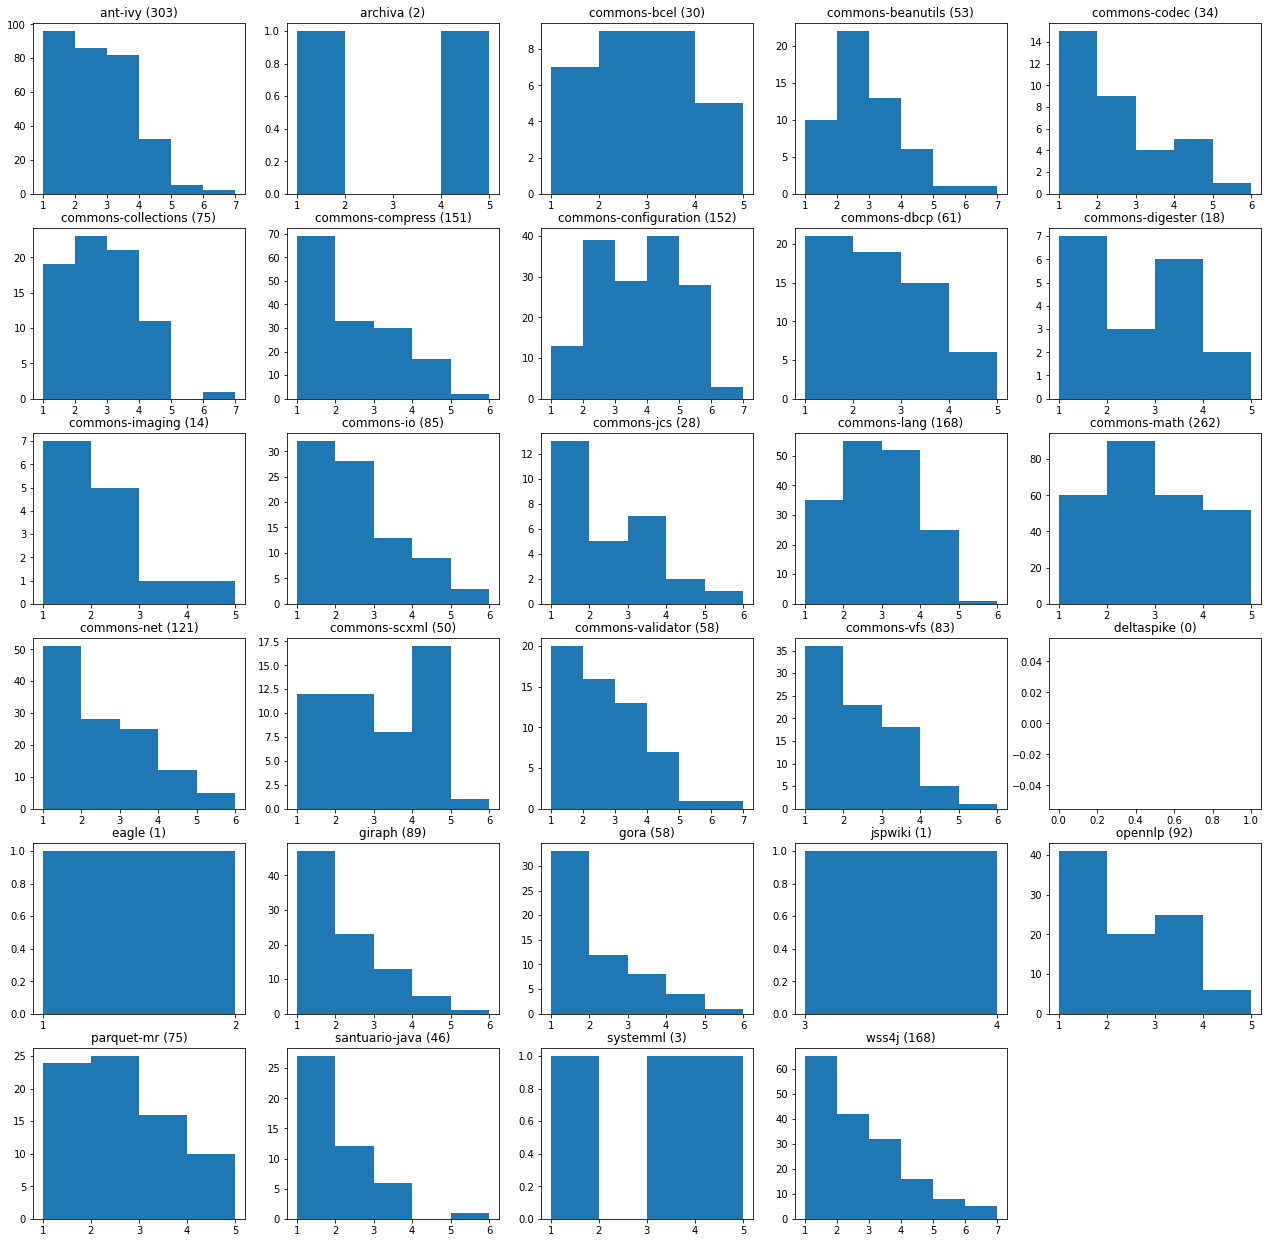

In [125]:
import matplotlib.pyplot as plt 

#skipped = []
fig = plt.figure(figsize = (22,22))
for i, proj in enumerate(all_consensus_commits.keys()):
    ax = fig.add_subplot(6, 5, i+1)
    if len(f1_f2_n_uniq_labels[proj]) == 0:
        #skipped.append(proj)
        ax.hist([])
        ax.set_title("{} ({})".format(proj, len(f1_f2_n_uniq_labels[proj])))
        continue 

    vs = list(f1_f2_n_uniq_labels[proj].values())
    bin_cand = list(np.unique(vs))
    bins = list(np.arange(np.min(bin_cand), np.max(bin_cand) + 2, 1))
    ax.hist(vs, bins = bins)
    ax.set_xticks(bins)
    ax.set_xticklabels(bins)
    ax.set_title("{} ({})".format(proj, len(vs)))
plt.show()
#print (skipped)


In [99]:
hash_and_n_pairs = list(f1_f2_n_uniq_labels['ant-ivy'].items())
hash_and_n_pairs = sorted(hash_and_n_pairs, key = lambda v:v[1], reverse = True)

#### Get parsed changes info (from Seongmin's)

In [102]:
import change_utils
changes_df = {}
changes_df['ant-ivy'] = change_utils.get_change_df('ant-ivy', "../data/parsed")

100%|██████████| 303/303 [00:02<00:00, 149.89it/s]


In [144]:
# one of three cases: 1) not in master branch (22), 2) none commited (1), 3) only delete files (2) => 25 commits
diffs = list(set(ant_ivy_prod_chg_commits) - set(changes_df['ant-ivy'].index.values))
len(diffs)

25

#### F3. at least more than one method have been modified 

In [147]:
# compute chgdat vectors 
from hunk_utils import get_changed_method
from dist_utils import compute_change_vector

f1_f2_f3_commits_chgdvs= {}
for commit in tqdm(ant_ivy_prod_chg_commits):
    if commit in diffs: 
        continue 

    chgdat_vector,_ = compute_change_vector(commit, changes_df['ant-ivy'], n_min_mod=1)
    if chgdat_vector is None:
        continue 
    f1_f2_f3_commits_chgdvs[commit] = chgdat_vector

100%|██████████| 303/303 [00:34<00:00,  8.78it/s]


In [149]:
len(ant_ivy_prod_chg_commits), len(f1_f2_f3_commits_chgdvs)

(303, 150)

In [151]:
list(f1_f2_f3_commits_chgdvs.items())[0][1]

{('org.apache.ivy.util.url#BasicURLHandler',
  'disconnect(URLConnection)'): ['2007 Jun 05 12:02', '2009 Dec 21 23:07', '2009 Jul 27 22:32'],
 ('org.apache.ivy.util.url#BasicURLHandler',
  'readResponseBody(HttpURLConnection)'): ['2009 Jul 27 22:32']}

#### F4. none changed in the past

In [153]:
f1_f2_f3_f4_commits = []
for commit, mth_chgd_vs in f1_f2_f3_commits_chgdvs.items():
    if any([len(vs) > 1 for vs in mth_chgd_vs.values()]):
        f1_f2_f3_f4_commits.append(commit)

In [154]:
len(f1_f2_f3_commits_chgdvs), len(f1_f2_f3_f4_commits)

(150, 132)

In [160]:
#os.makedirs("../data/cands", exist_ok = True)
#cand_file = "../data/cands/ant_ivy.csv" 
#pd.DataFrame({'commit':f1_f2_f3_f4_commits}).to_csv(cand_file)

in total, for ant-ivy, we can use 132 commits